In [6]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from collections import Counter
import umap
import networkx as nx
from itertools import permutations 
import hdbscan

In [7]:
class Profile():
    def __init__(self, filename):
        self._metadata = {}
        self._projects = {}
        self._votes = {}
        with open(filename, "r", encoding="utf8") as self.file:
            self.__read_lines()

        self.__convert_projects()
        self.__convert_votes()
        
    @property
    def ballots(self):
        return self._ballots
        
    def __convert_projects(self):
        self._projectid_to_index = {}
        tmp = {}
        for i, (proj_id, budget) in enumerate(self._projects.items()):
            self._projectid_to_index[proj_id] = i
            tmp[i] = budget
        self._projects = tmp
        
    def __convert_votes(self):
        self._votes = [np.array([self._projectid_to_index[x]]) if isinstance(x, int) else np.array([self._projectid_to_index[int(y)] for y in x.split(",")]) for x in self._votes.values()]
        self._ballots = np.zeros((self._metadata["num_votes"], self._metadata["num_projects"]))
        for i, vote in enumerate(self._votes):
            self._ballots[i,vote] = 1
       
    def __read_lines(self):
        _sections = {"META":self._metadata, 
                     "PROJECTS":self._projects, 
                     "VOTES":self._votes}
        _slices = {"key":"value",
                   "project_id":"cost",
                   "voter_id":"vote"}
        
        for line in self.file:
            line = line.strip()

            items = line.split(";")
            # find the right index for one of the properties (value, cost, vote)
            try:
                index = items.index(_slices[items[0]])
            except KeyError:
                pass
            else:
                continue 
            
            # switch to a new dict when a new section is found
            try: 
                _current = _sections[line]
            except KeyError:
                pass
            else:
                continue
            
            # read data
            try:
                try:
                    key = int(items[0])
                except ValueError:
                    key = items[0]
                _current[key] = int(items[index])
            except IndexError:
                pass
            except ValueError:
                _current[key] = items[index]

In [8]:
with open("data//sorted_files.pkl", 'rb') as f:
    file_division = pickle.load(f)

In [10]:
approval_profile_files = sorted(file_division['approval'], key=lambda x: x[2], reverse=True)

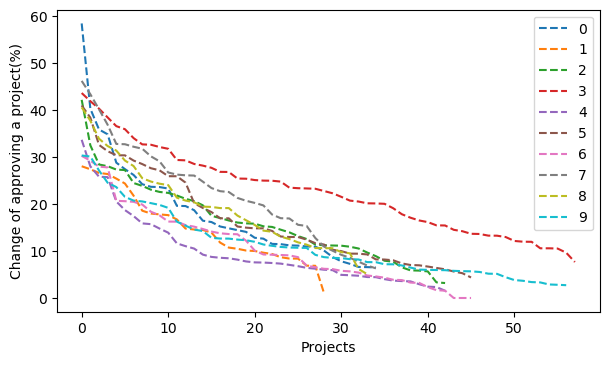

In [11]:
rcParams['figure.figsize'] = 7, 4
rcParams['figure.dpi'] = 100
rcParams.update({'font.size': 10})
for i in range(10):
    x = Profile(approval_profile_files[i][0])
    plt.plot(x.ballots.mean(0)*100,'--',label=i)
plt.legend()
plt.xlabel("Projects")
plt.ylabel("Change of approving a project(%)")
plt.show()

In [30]:
i = 1
old_data = Profile(approval_profile_files[i][0]).ballots

# data = [x/sum(x) if sum(x) else x for x in old_data]
data = old_data

In [31]:
x,y = np.unique(data, return_counts=True, axis=0)
len(y), len(data)
# sorted(y, reverse=True)

(3281, 8275)

In [32]:
reducer = umap.UMAP(n_components=2, n_neighbors=50, metric='manhattan')
reducer.fit(data)
embedding = reducer.transform(data)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(embedding == reducer.embedding_))
embedding.shape

(8275, 2)

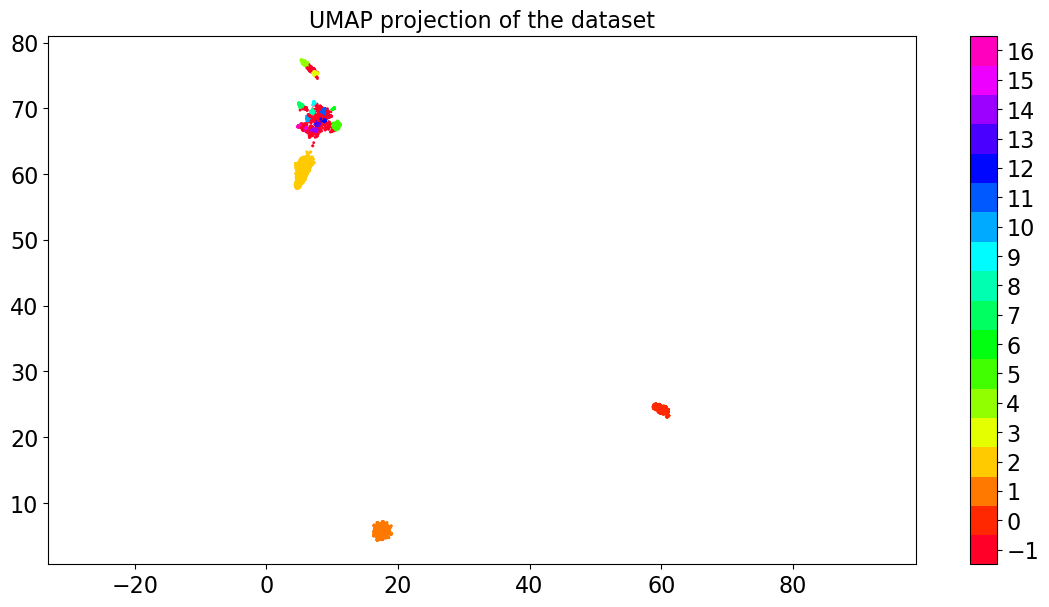

In [33]:
# n_clusters = 10
# k = KMeans(n_clusters).fit(embedding)

# n_clusters = 10
# k = GaussianMixture(n_clusters).fit(embedding)
# k.labels_ = k.predict(embedding)

# k = DBSCAN(0.45, len(data)//250).fit(embedding)
# n_clusters = max(k.labels_) + 1

k = hdbscan.HDBSCAN(min_cluster_size=len(data)//100, gen_min_span_tree=True).fit(embedding)
n_clusters = max(k.labels_) + 1

# # Visualization of HDBSCAN
# import seaborn as sns
# k.minimum_spanning_tree_.plot(edge_cmap='viridis',
#                                       edge_alpha=0.6,
#                                       node_size=10,
#                                       edge_linewidth=1)
# plt.show()

# k.condensed_tree_.plot()
# plt.show()

# k.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
# plt.show()

rcParams['figure.figsize'] = 14, 7
rcParams['figure.dpi'] = 100
rcParams.update({'font.size': 16})

plt.scatter(embedding[:, 0], embedding[:, 1], c=k.labels_, s=1, cmap='gist_rainbow')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(-1, n_clusters+1)-0.5).set_ticks(np.arange(-1, n_clusters))
plt.title('UMAP projection of the dataset', fontsize=16)
plt.show()

if embedding.shape[1] >= 4:
    plt.scatter(embedding[:, 2], embedding[:, 3], c=k.labels_, s=1, cmap='gist_rainbow')
    plt.gca().set_aspect('equal', 'datalim')
    plt.colorbar(boundaries=np.arange(-1, n_clusters+1)-0.5).set_ticks(np.arange(-1, n_clusters))
    plt.title('UMAP projection of the dataset', fontsize=16)

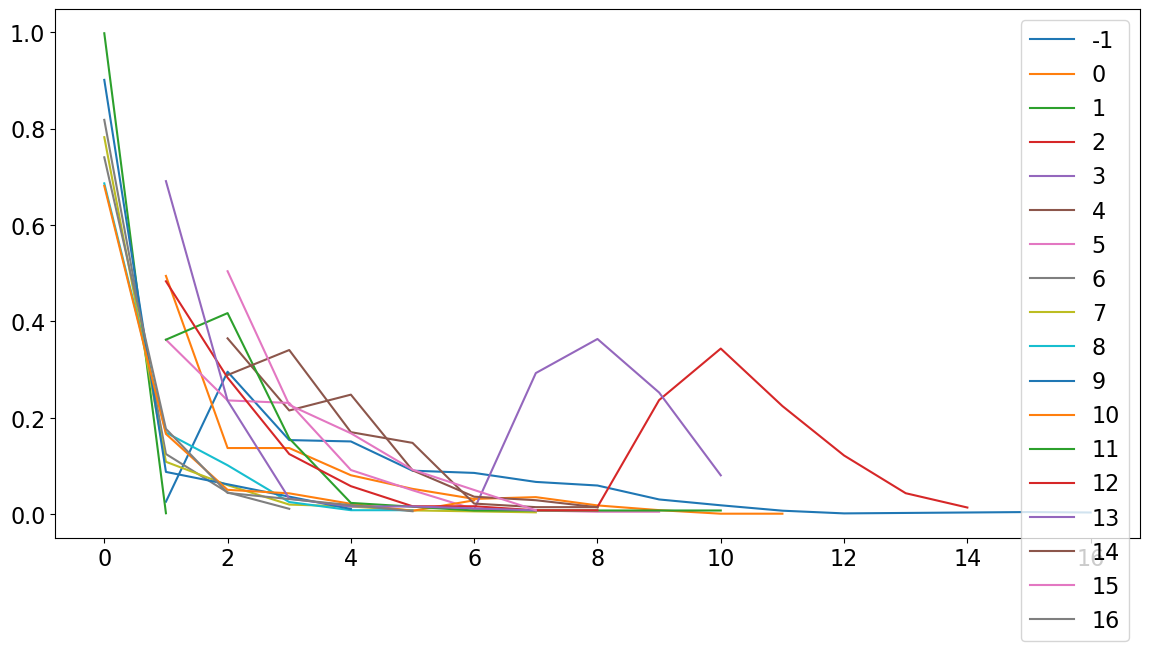

In [34]:
# print(f"number of approvals per cluster: {np.sum(cluster_mean, 1)}")
n_clusters = max(k.labels_) + 1

cluster_size = Counter(k.labels_) 

distance = {i:{} for i in range(-1,n_clusters)}
cluster_centers_ = [np.mean(old_data[k.labels_ == i],0) for i in range(n_clusters)]
for c, ballot in zip(k.labels_, old_data):
    dis = int(np.abs(ballot - cluster_centers_[c]).sum())
    try:
        distance[c][dis] += 1/cluster_size[c]
    except KeyError:
        distance[c][dis] = 1/cluster_size[c]
        
for c, dist in distance.items():
    plt.plot(*zip(*sorted(dist.items())), label=c)
plt.legend()
plt.show()

0
{0: 0.001226993865030675, 1: 0.049079754601226995, 2: 0.13987730061349693, 3: 0.0687116564417178, 4: 0.0, 5: 0.06993865030674846, 6: 0.13374233128834356, 7: 0.16319018404907976, 8: 0.05030674846625767, 9: 0.12392638036809817, 10: 0.018404907975460124, 11: 0.08588957055214724, 12: 0.08711656441717791, 13: 0.0834355828220859, 14: 0.04539877300613497, 15: 0.09693251533742331, 16: 0.06503067484662577, 17: 0.05644171779141104, 18: 0.06257668711656442, 19: 0.0, 20: 0.9901840490797545, 21: 0.06134969325153374, 22: 0.025766871165644172, 23: 0.04171779141104295, 24: 0.03558282208588957, 25: 0.03803680981595092, 26: 0.025766871165644172, 27: 0.008588957055214725, 28: 0.00245398773006135}
815


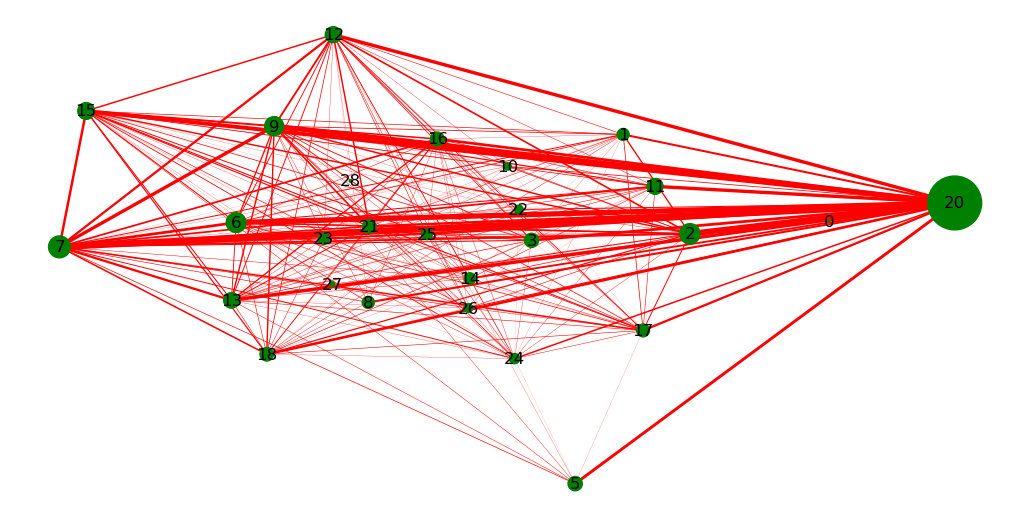

1
{0: 1.0, 1: 0.0, 2: 0.0004317789291882556, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0017271157167530224, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0012953367875647669, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.0, 23: 0.0, 24: 0.0, 25: 0.0, 26: 0.0, 27: 0.0, 28: 0.0}
2316


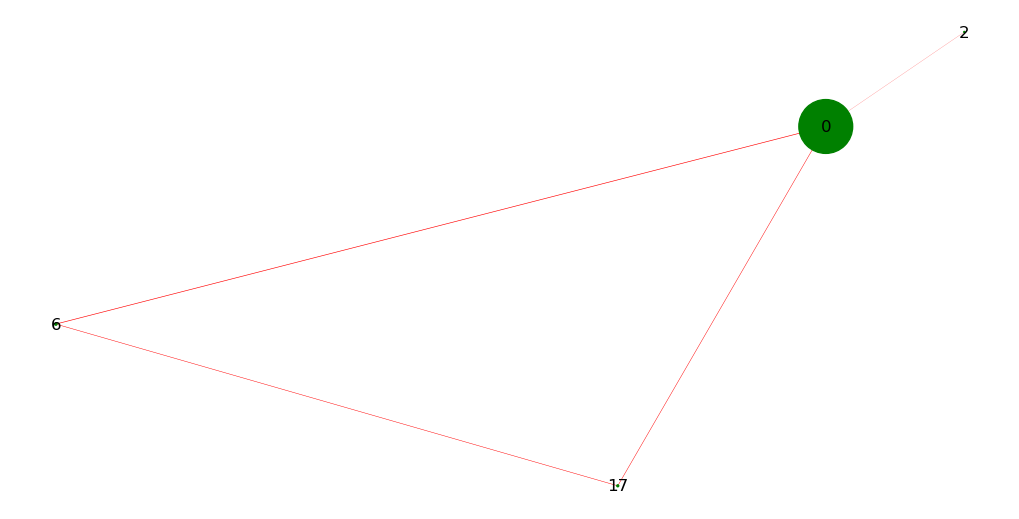

2
{0: 0.0, 1: 0.6659471127900701, 2: 0.7598488936859147, 3: 0.7992444684295736, 4: 0.7803561791689153, 5: 0.6880733944954128, 6: 0.6270912034538586, 7: 0.5504587155963303, 8: 0.5493793847814356, 9: 0.5391257420399352, 10: 0.5213167835941717, 11: 0.5671883432271991, 12: 0.4813815434430653, 13: 0.43712898003237993, 14: 0.4846195358877496, 15: 0.4452239611440907, 16: 0.34646519158121963, 17: 0.2876416621694549, 18: 0.32379924446842956, 19: 0.0, 20: 0.0, 21: 0.3232595790609822, 22: 0.26821370750134915, 23: 0.26497571505666484, 24: 0.28440366972477066, 25: 0.2951969778737183, 26: 0.23367512142471666, 27: 0.21640582838640043, 28: 0.0}
1853


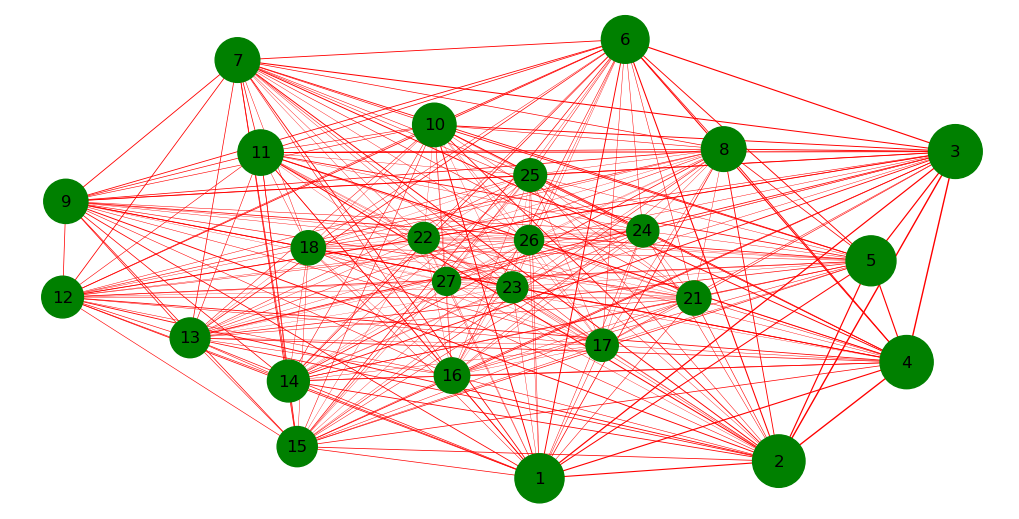

3
{0: 0.0, 1: 0.8080808080808081, 2: 0.15151515151515152, 3: 0.35353535353535354, 4: 0.04040404040404041, 5: 0.16161616161616163, 6: 0.5252525252525253, 7: 0.9191919191919192, 8: 0.2222222222222222, 9: 0.7373737373737373, 10: 0.35353535353535354, 11: 0.1717171717171717, 12: 0.5959595959595959, 13: 0.5555555555555556, 14: 0.32323232323232326, 15: 0.3939393939393939, 16: 0.26262626262626265, 17: 0.3939393939393939, 18: 0.21212121212121213, 19: 1.0, 20: 0.0, 21: 0.26262626262626265, 22: 0.09090909090909091, 23: 0.20202020202020202, 24: 0.16161616161616163, 25: 0.25252525252525254, 26: 0.15151515151515152, 27: 0.1111111111111111, 28: 0.0}
99


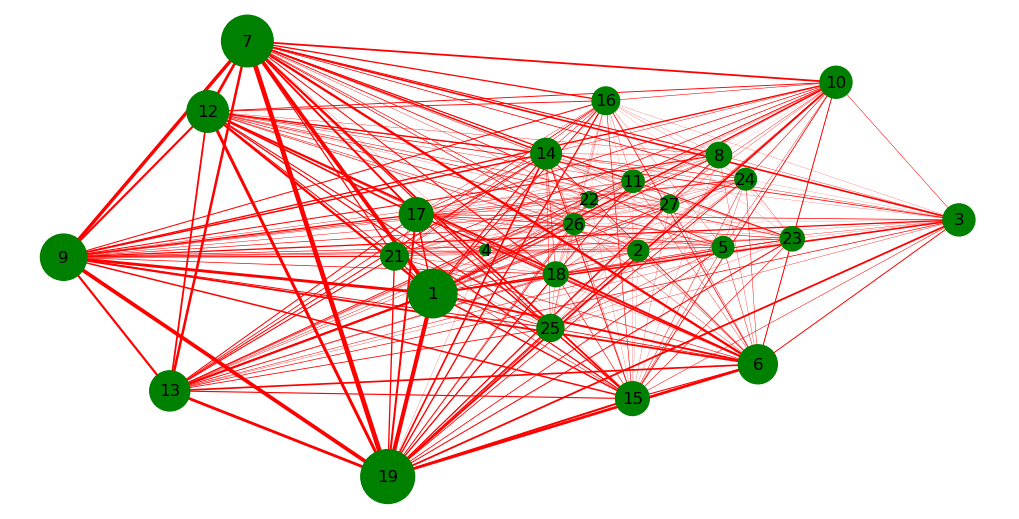

4
{0: 0.0, 1: 0.9963503649635036, 2: 0.08759124087591241, 3: 0.145985401459854, 4: 0.12773722627737227, 5: 0.16423357664233576, 6: 0.12043795620437957, 7: 0.06204379562043796, 8: 0.11313868613138686, 9: 0.0948905109489051, 10: 0.3248175182481752, 11: 0.051094890510948905, 12: 0.040145985401459854, 13: 0.06934306569343066, 14: 0.051094890510948905, 15: 0.058394160583941604, 16: 0.11313868613138686, 17: 0.12043795620437957, 18: 0.09124087591240876, 19: 1.0, 20: 0.0, 21: 0.040145985401459854, 22: 0.072992700729927, 23: 0.06204379562043796, 24: 0.032846715328467155, 25: 0.0364963503649635, 26: 0.021897810218978103, 27: 0.10948905109489052, 28: 0.0}
274


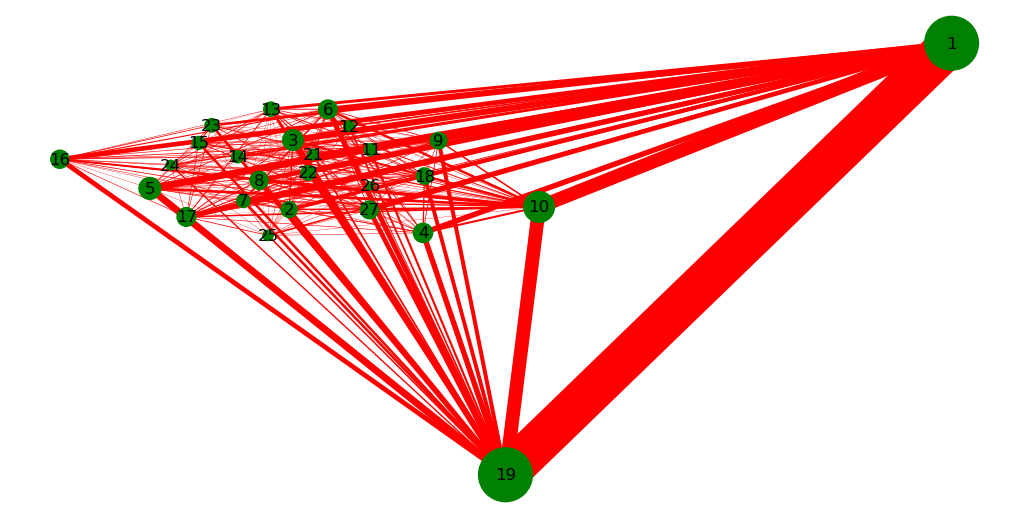

5
{0: 0.0, 1: 1.0, 2: 0.07874015748031496, 3: 0.015748031496062992, 4: 0.06299212598425197, 5: 0.11811023622047244, 6: 0.16010498687664043, 7: 0.031496062992125984, 8: 0.06299212598425197, 9: 0.05511811023622047, 10: 0.2152230971128609, 11: 0.07611548556430446, 12: 0.026246719160104987, 13: 0.05774278215223097, 14: 0.05774278215223097, 15: 0.03674540682414698, 16: 0.06824146981627296, 17: 0.06299212598425197, 18: 0.05511811023622047, 19: 0.0, 20: 0.03412073490813648, 21: 0.02099737532808399, 22: 0.07874015748031496, 23: 0.05511811023622047, 24: 0.015748031496062992, 25: 0.02099737532808399, 26: 0.01837270341207349, 27: 0.06299212598425197, 28: 0.010498687664041995}
381


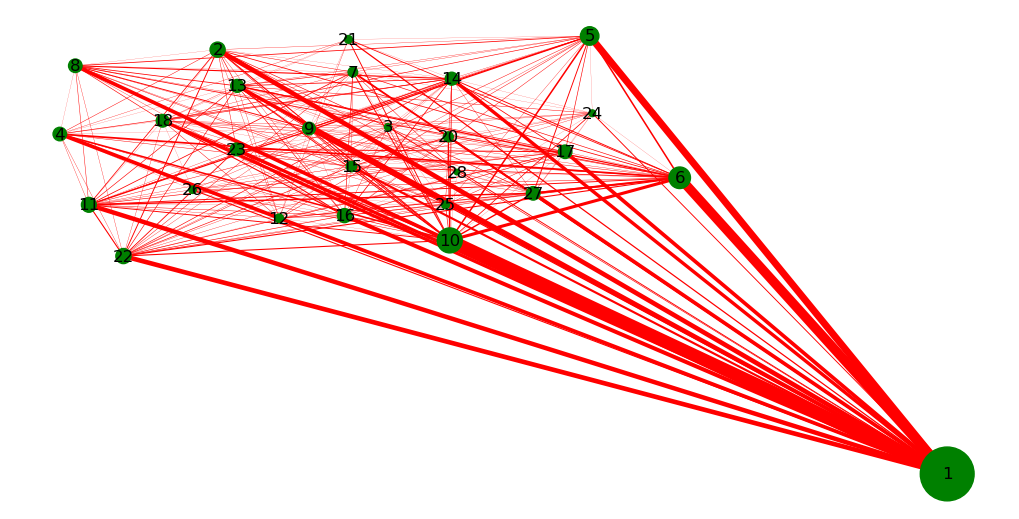

6
{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.011363636363636364, 4: 0.011363636363636364, 5: 0.0, 6: 0.011363636363636364, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.056818181818181816, 16: 0.011363636363636364, 17: 1.0, 18: 0.11363636363636363, 19: 0.022727272727272728, 20: 0.0, 21: 0.0, 22: 0.011363636363636364, 23: 0.022727272727272728, 24: 0.0, 25: 0.0, 26: 0.0, 27: 0.011363636363636364, 28: 0.0}
88


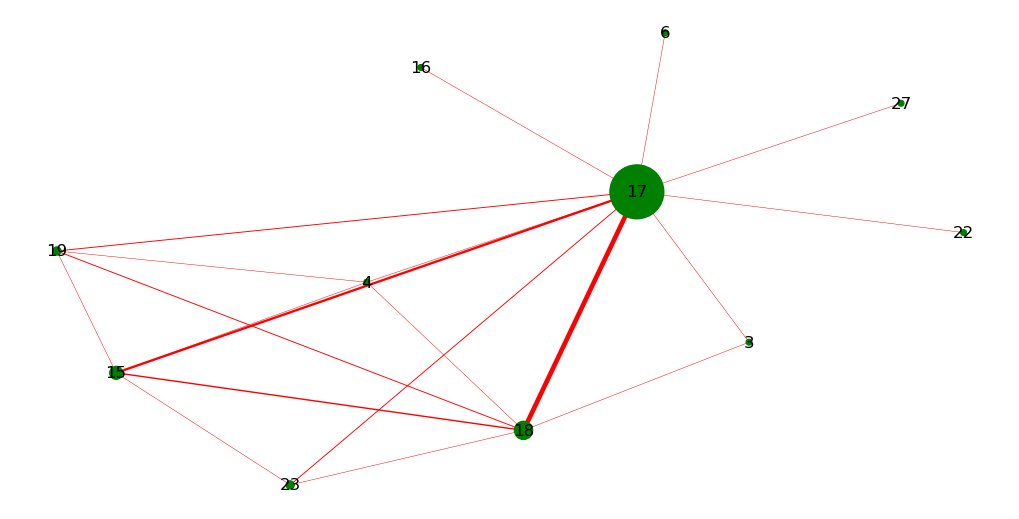

7
{0: 0.0, 1: 0.0, 2: 0.004032258064516129, 3: 0.024193548387096774, 4: 0.028225806451612902, 5: 0.004032258064516129, 6: 0.024193548387096774, 7: 0.004032258064516129, 8: 0.05241935483870968, 9: 0.016129032258064516, 10: 0.028225806451612902, 11: 0.024193548387096774, 12: 0.016129032258064516, 13: 0.0, 14: 0.024193548387096774, 15: 0.028225806451612902, 16: 0.024193548387096774, 17: 0.06048387096774194, 18: 0.004032258064516129, 19: 1.0, 20: 0.0, 21: 0.0, 22: 0.008064516129032258, 23: 0.020161290322580645, 24: 0.0, 25: 0.004032258064516129, 26: 0.012096774193548387, 27: 0.012096774193548387, 28: 0.0}
248


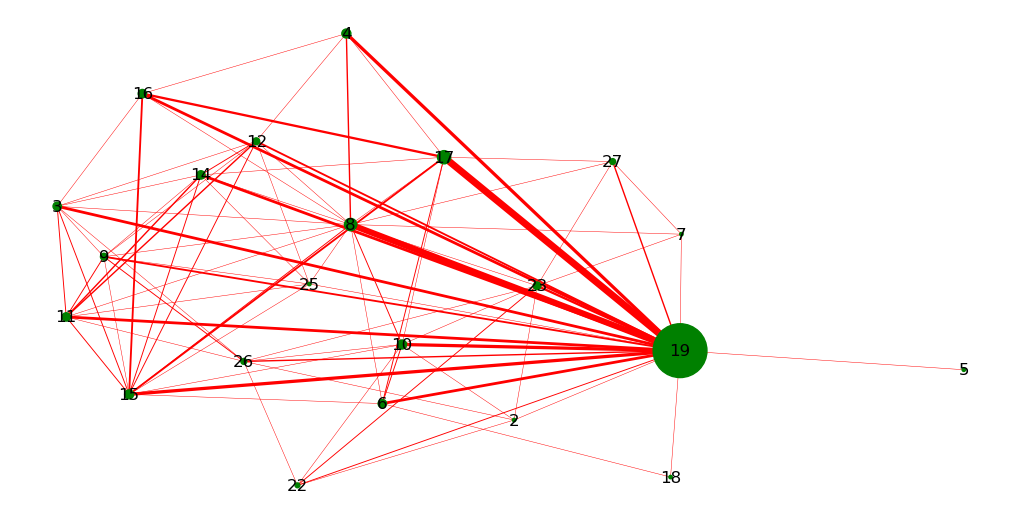

8
{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.9915254237288136, 6: 0.01694915254237288, 7: 0.00847457627118644, 8: 0.06779661016949153, 9: 0.01694915254237288, 10: 0.059322033898305086, 11: 0.0423728813559322, 12: 0.01694915254237288, 13: 0.03389830508474576, 14: 0.0423728813559322, 15: 0.01694915254237288, 16: 0.01694915254237288, 17: 0.025423728813559324, 18: 0.01694915254237288, 19: 0.00847457627118644, 20: 0.0, 21: 0.0, 22: 0.0423728813559322, 23: 0.03389830508474576, 24: 0.00847457627118644, 25: 0.00847457627118644, 26: 0.03389830508474576, 27: 0.0, 28: 0.0}
118


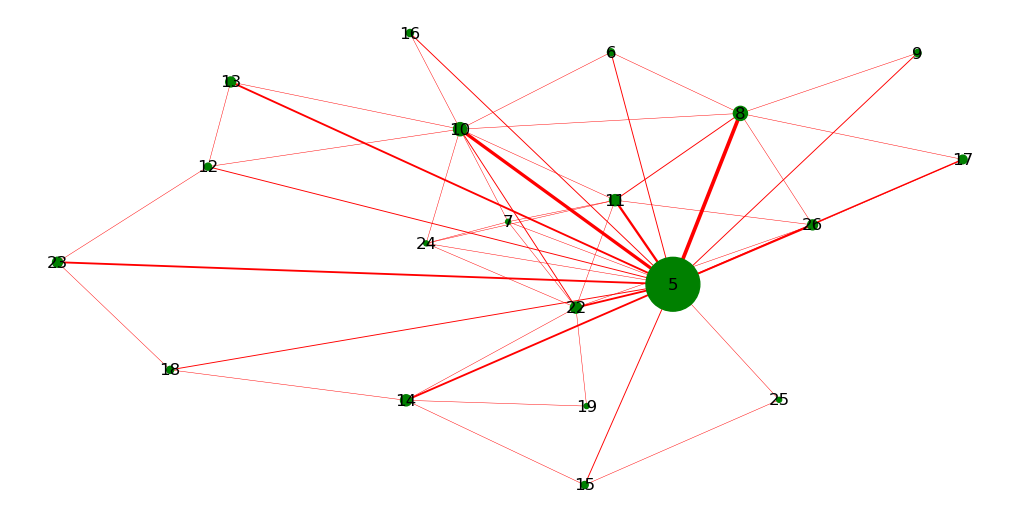

9
{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.01098901098901099, 6: 0.0, 7: 0.0, 8: 0.02197802197802198, 9: 0.0, 10: 1.0, 11: 0.01098901098901099, 12: 0.0, 13: 0.0, 14: 0.01098901098901099, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.01098901098901099, 19: 0.0, 20: 0.0, 21: 0.02197802197802198, 22: 0.01098901098901099, 23: 0.0, 24: 0.02197802197802198, 25: 0.0, 26: 0.01098901098901099, 27: 0.0, 28: 0.0}
91


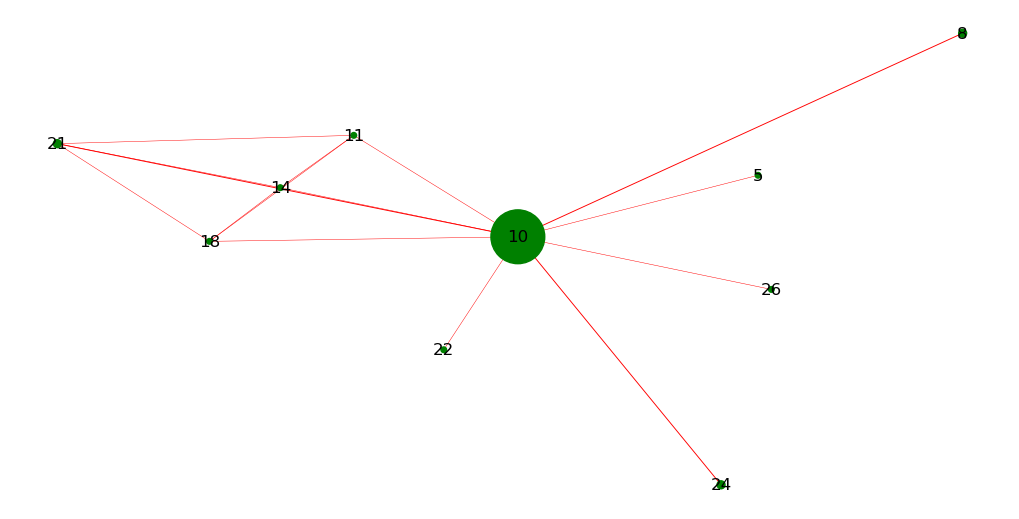

10
{0: 0.0, 1: 0.007246376811594203, 2: 1.0, 3: 0.0, 4: 0.007246376811594203, 5: 0.021739130434782608, 6: 0.06521739130434782, 7: 0.028985507246376812, 8: 0.036231884057971016, 9: 0.028985507246376812, 10: 0.050724637681159424, 11: 0.07971014492753623, 12: 0.014492753623188406, 13: 0.050724637681159424, 14: 0.043478260869565216, 15: 0.021739130434782608, 16: 0.007246376811594203, 17: 0.014492753623188406, 18: 0.007246376811594203, 19: 0.028985507246376812, 20: 0.0, 21: 0.043478260869565216, 22: 0.050724637681159424, 23: 0.036231884057971016, 24: 0.014492753623188406, 25: 0.014492753623188406, 26: 0.0, 27: 0.014492753623188406, 28: 0.007246376811594203}
138


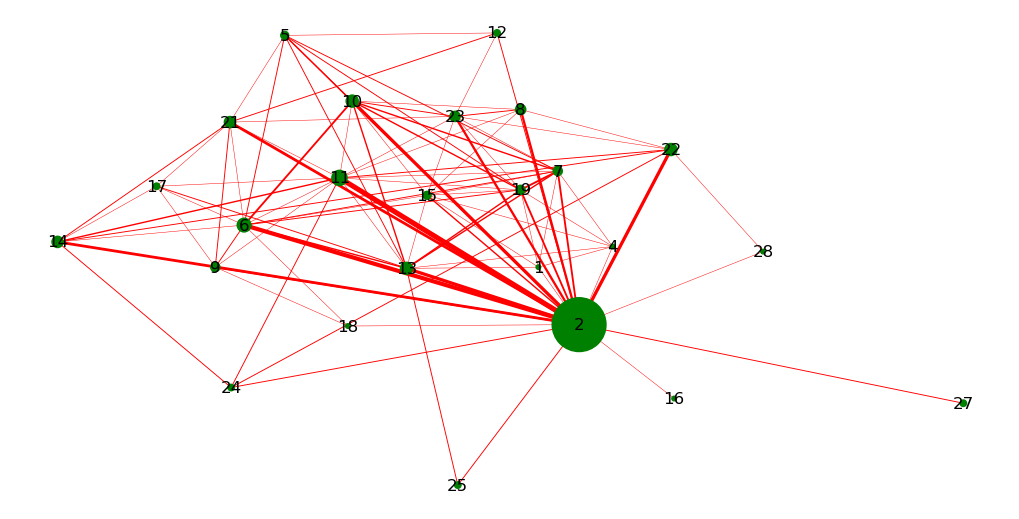

11
{0: 0.0, 1: 0.007874015748031496, 2: 0.0, 3: 0.007874015748031496, 4: 0.007874015748031496, 5: 0.015748031496062992, 6: 0.03937007874015748, 7: 0.047244094488188976, 8: 0.6850393700787402, 9: 0.015748031496062992, 10: 0.015748031496062992, 11: 0.015748031496062992, 12: 0.10236220472440945, 13: 0.015748031496062992, 14: 0.047244094488188976, 15: 0.023622047244094488, 16: 0.11023622047244094, 17: 0.023622047244094488, 18: 0.11023622047244094, 19: 0.015748031496062992, 20: 0.0, 21: 0.007874015748031496, 22: 0.031496062992125984, 23: 0.07086614173228346, 24: 0.023622047244094488, 25: 0.0, 26: 0.16535433070866143, 27: 0.10236220472440945, 28: 0.03937007874015748}
127


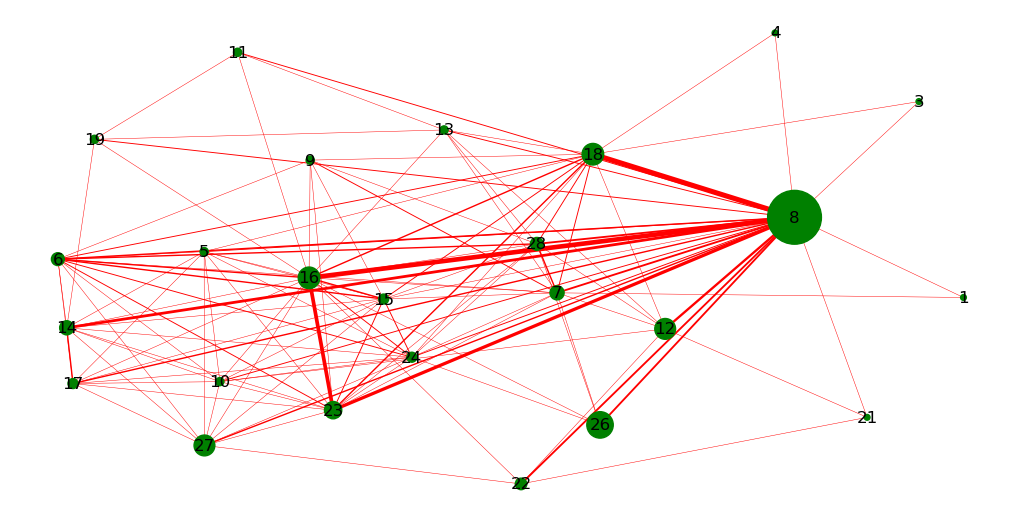

12
{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.008333333333333333, 4: 0.0, 5: 0.06666666666666667, 6: 0.8083333333333333, 7: 0.06666666666666667, 8: 0.025, 9: 0.09166666666666666, 10: 0.05, 11: 0.05, 12: 0.025, 13: 0.075, 14: 0.058333333333333334, 15: 0.008333333333333333, 16: 0.05, 17: 0.041666666666666664, 18: 0.05, 19: 0.008333333333333333, 20: 0.0, 21: 0.0, 22: 0.31666666666666665, 23: 0.03333333333333333, 24: 0.03333333333333333, 25: 0.008333333333333333, 26: 0.03333333333333333, 27: 0.025, 28: 0.025}
120


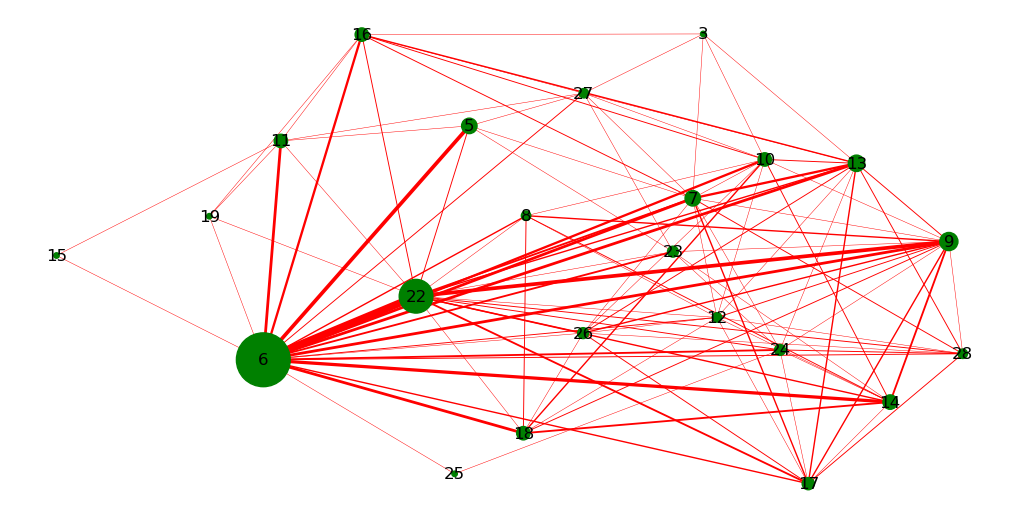

13
{0: 0.0, 1: 0.0, 2: 0.0, 3: 1.0, 4: 0.0, 5: 0.18699186991869918, 6: 0.08943089430894309, 7: 0.024390243902439025, 8: 0.0975609756097561, 9: 0.08130081300813008, 10: 0.04878048780487805, 11: 0.06504065040650407, 12: 0.06504065040650407, 13: 0.024390243902439025, 14: 0.04065040650406504, 15: 0.016260162601626018, 16: 0.016260162601626018, 17: 0.032520325203252036, 18: 0.008130081300813009, 19: 0.0, 20: 0.0, 21: 0.032520325203252036, 22: 0.056910569105691054, 23: 0.04065040650406504, 24: 0.0, 25: 0.016260162601626018, 26: 0.024390243902439025, 27: 0.04878048780487805, 28: 0.008130081300813009}
123


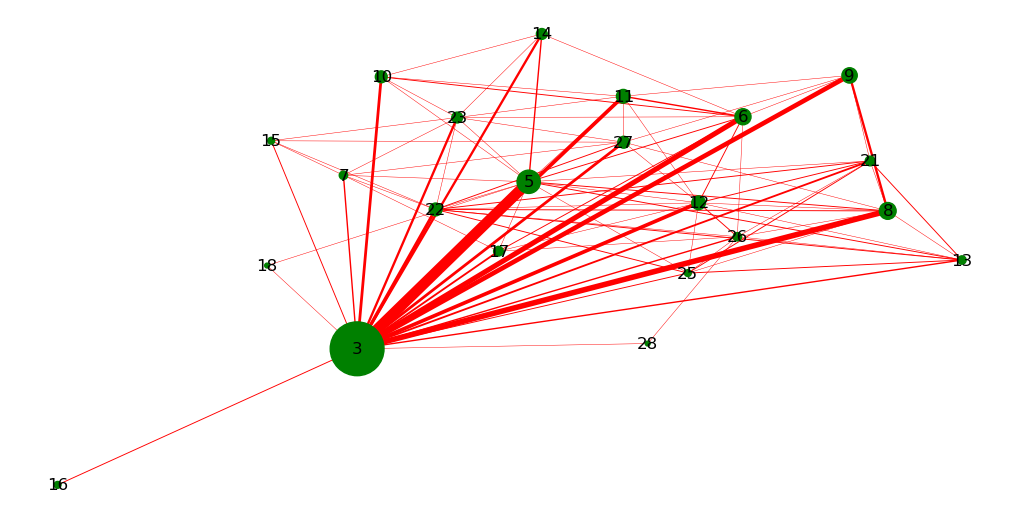

14
{0: 0.0, 1: 0.14814814814814814, 2: 0.9037037037037037, 3: 1.0, 4: 0.32592592592592595, 5: 0.18518518518518517, 6: 0.1259259259259259, 7: 0.13333333333333333, 8: 0.14074074074074075, 9: 0.06666666666666667, 10: 0.07407407407407407, 11: 0.13333333333333333, 12: 0.17037037037037037, 13: 0.0962962962962963, 14: 0.1259259259259259, 15: 0.007407407407407408, 16: 0.06666666666666667, 17: 0.022222222222222223, 18: 0.06666666666666667, 19: 0.044444444444444446, 20: 0.0, 21: 0.0962962962962963, 22: 0.07407407407407407, 23: 0.014814814814814815, 24: 0.014814814814814815, 25: 0.022222222222222223, 26: 0.014814814814814815, 27: 0.014814814814814815, 28: 0.0}
135


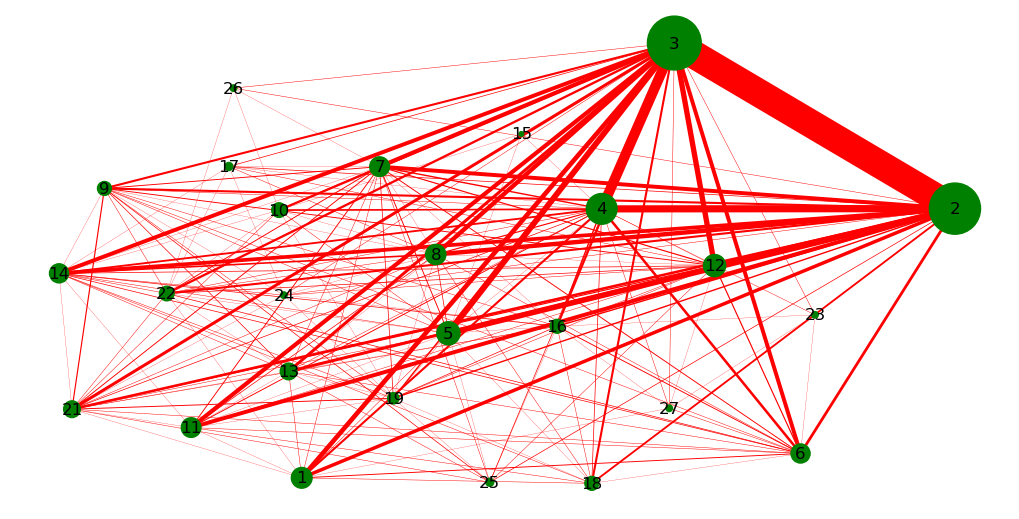

15
{0: 0.008403361344537815, 1: 0.10084033613445378, 2: 0.5126050420168067, 3: 0.0, 4: 1.0, 5: 0.7478991596638656, 6: 0.15126050420168066, 7: 0.08403361344537816, 8: 0.16806722689075632, 9: 0.06722689075630252, 10: 0.14285714285714285, 11: 0.10084033613445378, 12: 0.05042016806722689, 13: 0.05042016806722689, 14: 0.12605042016806722, 15: 0.01680672268907563, 16: 0.058823529411764705, 17: 0.03361344537815126, 18: 0.10084033613445378, 19: 0.0, 20: 0.0, 21: 0.01680672268907563, 22: 0.058823529411764705, 23: 0.04201680672268908, 24: 0.0, 25: 0.008403361344537815, 26: 0.01680672268907563, 27: 0.03361344537815126, 28: 0.0}
119


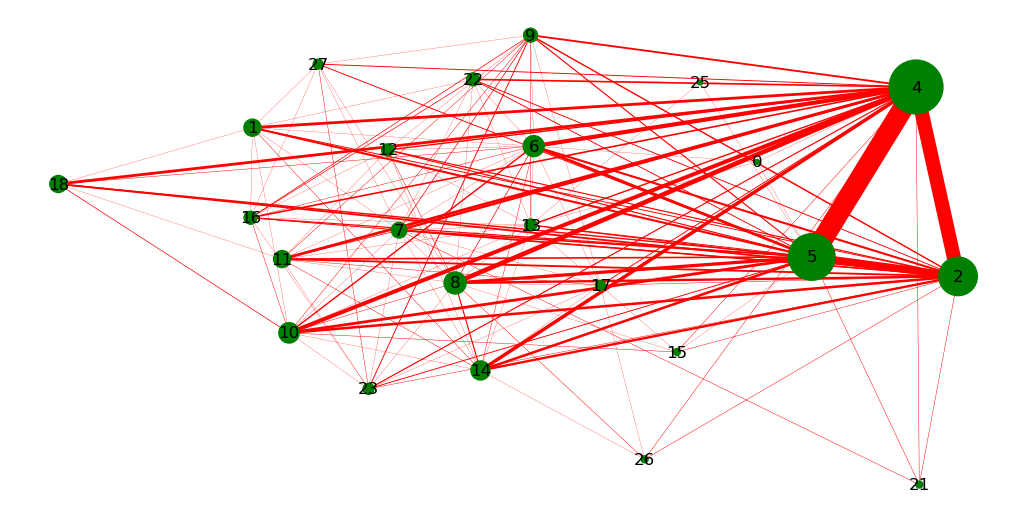

16
{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 1.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.05063291139240506, 9: 0.012658227848101266, 10: 0.05063291139240506, 11: 0.03164556962025317, 12: 0.0, 13: 0.0189873417721519, 14: 0.012658227848101266, 15: 0.0379746835443038, 16: 0.0189873417721519, 17: 0.006329113924050633, 18: 0.03164556962025317, 19: 0.006329113924050633, 20: 0.0, 21: 0.0, 22: 0.04430379746835443, 23: 0.04430379746835443, 24: 0.0, 25: 0.006329113924050633, 26: 0.012658227848101266, 27: 0.006329113924050633, 28: 0.0}
158


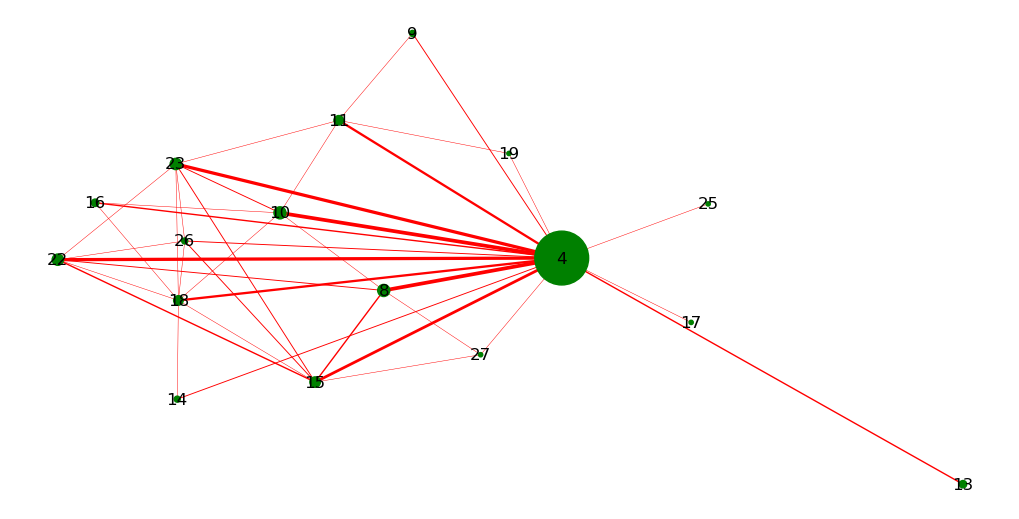

In [35]:
clusters = [old_data[k.labels_ == i] for i in range(n_clusters)]
for see_cluster in range(n_clusters):
    print(see_cluster)
#     print(np.where(np.mean(clusters[see_cluster],0) > 0.75)[0])
    print({i:x for i,x in enumerate(np.mean(clusters[see_cluster],0))})
    print(len(clusters[see_cluster]))
    cluster_0 = Counter([tuple(np.where(x == 1)[0]) for x in clusters[see_cluster]])

    edge_dict = {}
    for key,value in cluster_0.items():
        for perm in permutations(key, 2):
            try:
                edge_dict[(perm[0], perm[1])] += value
            except KeyError:
                try: 
                    edge_dict[(perm[1], perm[0])] += value
                except KeyError:
                    edge_dict[(perm[0], perm[1])] = value

    edge_list = [(*key, {'weight':value}) for key,value in edge_dict.items()]
#     print([x for x in edge_list if x[2]['weight'] > 0.25*len(clusters[see_cluster])])

    G = nx.Graph()
    G.add_nodes_from(sorted(set([y for x in cluster_0.keys() for y in x])))
    G.add_edges_from(edge_list)
    rcParams['figure.figsize'] = 10, 5
    rcParams['figure.dpi'] = 100
    options = {
        'node_color': 'g',
        'edge_color':'r'
    }
    edges = G.edges()
    weights = [G[u][v]['weight'] for u,v in edges]
    weights /= np.median(weights)*3
    
    nodes = G.nodes()
    s = np.sum(clusters[see_cluster],0)
    s /= max(s)
    s *= 1500
    node_size = [s[n] for n in nodes]

    nx.draw_kamada_kawai(G, node_size=node_size, with_labels=True, edgelist=edges, width=weights, **options)
    plt.show()


In [17]:
sum(Profile(approval_profile_files[i][0]).ballots)

array([2318., 2265., 2201., 2181., 2101., 2014., 1800., 1536., 1486.,
       1471., 1458., 1382., 1222., 1205., 1197., 1151.,  975.,  887.,
        866.,  835.,  827.,  797.,  774.,  718.,  694.,  693.,  569.,
        567.,   89.])